In [1]:
print("Hello World!")

Hello World!


822/822 ━━━━━━━━━━━━━━━━━━━━ 348s 315ms/step - loss: 0.0144 - val_loss: 8.9963e-04 - learning_rate: 5.0000e-04
547/547 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step
MAE: 310.4409393973997
RMSE: 404.0704199154702
MAPE: 2.7551149857570216%
R² Score: 0.9761747989284432


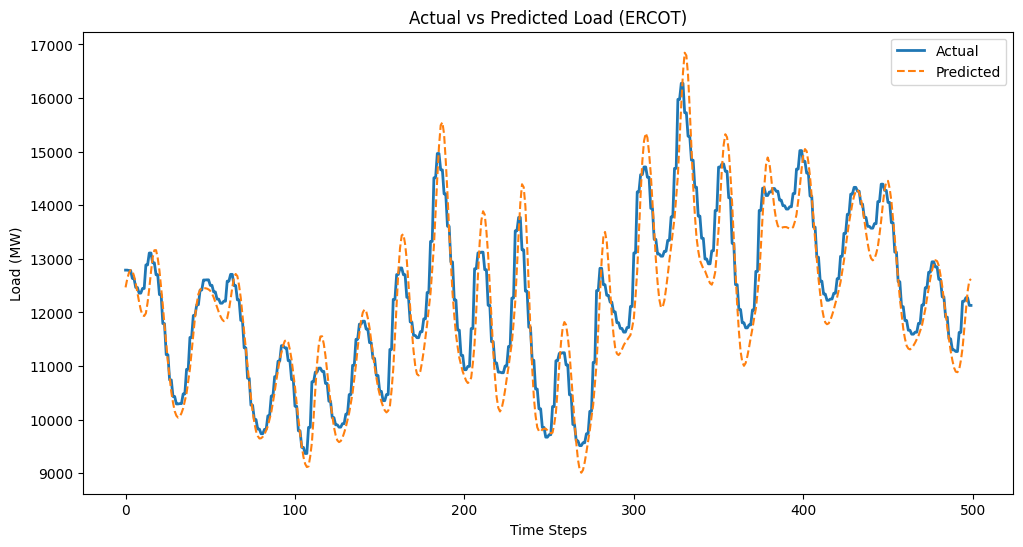

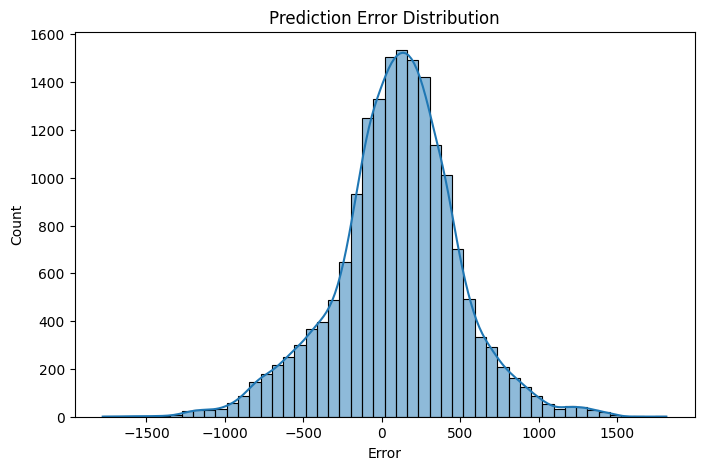

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Data
ercot_data = pd.read_excel('D:/1/Load/DataSet/LoadTexasERCOT.xlsx')
weather_data1 = pd.read_excel('D:/1/Load/DataSet/WeatherStation1.xlsx')
weather_data2 = pd.read_excel('D:/1/Load/DataSet/WeatherStation2.xlsx')
weather_data3 = pd.read_excel('D:/1/Load/DataSet/WeatherStation3.xlsx')

# Convert timestamps
ercot_data['Hour_End'] = pd.to_datetime(ercot_data['Hour_End'])
ercot_data.set_index('Hour_End', inplace=True)

def process_weather_data(df):
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.set_index('Datetime', inplace=True)
    return df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

weather_data1 = process_weather_data(weather_data1)
weather_data2 = process_weather_data(weather_data2)
weather_data3 = process_weather_data(weather_data3)

# Merge data
merged_data = ercot_data.copy()
for weather_data in [weather_data1, weather_data2, weather_data3]:
    merged_data = merged_data.merge(weather_data, left_index=True, right_index=True, how='outer')

# Fill missing values
merged_data = merged_data.ffill().bfill()

# Ensure target column exists
if 'ERCOT' not in merged_data.columns:
    raise ValueError("The target column 'ERCOT' is missing from the dataset.")

# Feature Scaling
scaler = MinMaxScaler()
features = merged_data.drop(columns=['ERCOT'])
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)
scaled_data['ERCOT'] = MinMaxScaler().fit_transform(merged_data[['ERCOT']])

# Train-Test Split
train = scaled_data.loc['2012':'2014']
test = scaled_data.loc['2015']

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 24
x_train, y_train = create_sequences(train['ERCOT'].values, seq_length)
x_test, y_test = create_sequences(test['ERCOT'].values, seq_length)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build a Better Model with LSTM and Attention Mechanism
input_layer = Input(shape=(seq_length, 1))

# First LSTM Layer
lstm_1 = LSTM(128, return_sequences=True)(input_layer)
dropout_1 = Dropout(0.2)(lstm_1)

# Attention Mechanism
attention = Attention(use_scale=True)([dropout_1, dropout_1])
context_vector = Concatenate(axis=-1)([dropout_1, attention])

# Second LSTM Layer
lstm_2 = LSTM(64, return_sequences=False)(context_vector)
dropout_2 = Dropout(0.2)(lstm_2)

# Fully Connected Layer
dense_1 = Dense(32, activation='relu')(dropout_2)
dropout_3 = Dropout(0.2)(dense_1)

# Output Layer
output = Dense(1)(dropout_3)

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train Model
history = model.fit(
    x_train, y_train, 
    epochs=1, 
    batch_size=64, 
    validation_data=(x_test, y_test), 
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Predictions
predictions_scaled = model.predict(x_test)

# Inverse Scaling
dummy_array = np.zeros((predictions_scaled.shape[0], features.shape[1]))
dummy_array[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_array)[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], features.shape[1]-1))], axis=1))[:, 0]

# Metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R² Score: {r2}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()

# Histogram of Errors
plt.figure(figsize=(8, 5))
sns.histplot(y_test_actual - predictions, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()